# To Do

- Implement n_i^eq + relaxation 
- Implement intial densities  (now just set to 0), make sure that upper and lower boundary are set to 0.
- Implement input and output boundaries (bounch has been done already
- Implement pressure gradient (hence for in x diretion)
- Implement visualization 


In [610]:
import numpy as np
from sys import exit 
from types import SimpleNamespace
import matplotlib.pyplot as plt


def boltzmann_sim(self):
    """
    
    Simulation of the boltzmann lattice
    
    
    """
    
    input_check(self)
    sim, par = initialization(self)
    
    for i in range(10):
        par = shift_n(self, par)
        par = boundary_bounch(self, par)
        par = velocity(self, par)
        par = forcing(self, par)
        par = eq_n(self, par)
        par = relax_n(self, par)
        plt.imshow(par.rho)
        plt.show()
    
    return par

def input_check(self):
    if (self.L/self.res)%1 !=0 or (self.W/self.res)%1 != 0:
        exit('Choose width, height and res such that an integer ammount of points is generated.')

def initialization(self):
    """ Initializes arrays. 
    
    Parameters
    ----------
    self : NameSpace
        simulation constants 
        
    Returns
    -------
    par: NameSpace
        containing initialized parameter arrays
    
    """
    
    # Simulation parameters 
    par = SimpleNamespace()
    
    # Cartesian grid coordinates 
    self.grid_coord = np.meshgrid(np.linspace(0, self.L, self.L_n), np.linspace(0, self.W, self.W_n))
    
    # Integer grid coordinates
    self.grid_int_coord = np.meshgrid(range(self.L_n), range(self.W_n))
    
    # Density array
    par.n = 0.5*np.ones((self.L_n, self.W_n, len(self.e)), dtype = float)
    par.n[:,[0, self.W_in],:] = 0
    
    return self, par

def shift_n(self, par):
    """ Shifts densities according to their unit vectors. 
    
    Parameters
    ----------
    self : NameSpace
        simulation constants 
    par : NameSpace
        simulation parameters 
    
    Returns
    -------
    par: NameSpace
        updated simulation parameters
    
    """
    
    for i in range(len(self.e)):
        
        par.n[:,:,i] = np.roll(par.n[:,:,i], self.e[i], axis = [0, 1])
        
    return par

def boundary_bounch(self, par):
    """
    
    Takes the upper boundary and the lower boundary of a certain density vector. 
    Mirrors this vector and assigns the density accordingly. 
    
    Parameters
    ----------
    self : NameSpace
        simulation constants 
    par : NameSpace
        simulation parameters 
    
    Returns
    -------
    par: NameSpace
        updated simulation parameters
    
    """    
    
    # To keep track of exchanged boundaries
    exchanged = np.ones((len(self.e),), dtype = bool)
    
    for i in range(len(self.e)):
        if exchanged[i]:
            e_inv = -1 * self.e[i]
            j = np.argwhere(np.sum(e_inv == sim.e, axis = 1) == 2)[0]
            
            # Select upper and lower boundary 
            bd_1 = par.n[:,[0, self.W_in], i]
            bd_2 = par.n[:,[0, self.W_in], j]
            
            # Exchange densities accordingly 
            par.n[:,[0, self.W_in], i] = bd_2
            par.n[:,[0, self.W_in], j] = bd_1
            
            exchanged[i] = False
            exchanged[j] = False
            
    return par 

def eq_n(self, par):
    
    par.n_eq = np.zeros(np.shape(par.n), dtype = float)
    par.rho = np.mean(par.n, axis = 2)
   
    c = self.c
    u = par.u
 
    for i in range(len(self.e)):
        par.n_eq[:,:,i] = self.w[i]*par.rho/self.m*(1 + (3/c**2)*np.dot(u, self.e[i]) + 
                                         (9/(2*c**4))*np.dot(u, self.e[i])**2 -
                                         3/(2*c**2)*np.sum((u * u), axis = 2))
                                       
    return par 

def velocity(self, par):
    
    par.u = np.tensordot(par.n, self.e, axes = 1)

    return par

def forcing(self, par):
    #incorrect still, not sure if this is a x or y forcing 
    
    par.u[:, -3:, 0] = (1 - par.u[:, -3:, 0])*self.c*self.P

    return par 

def relax_n(self, par):
     
    par.n = (1 - 1/self.tau)*par.n + par.n_eq/self.tau
    
    return par
    

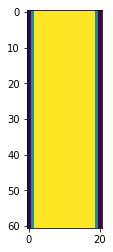

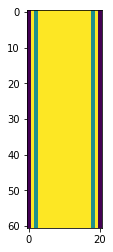

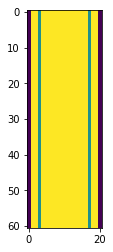

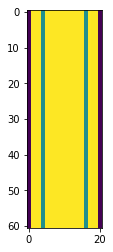

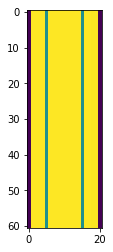

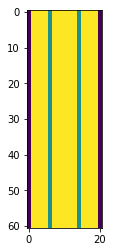

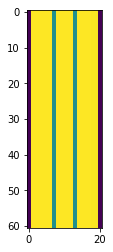

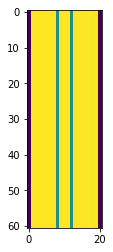

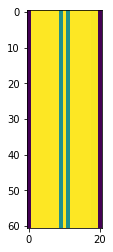

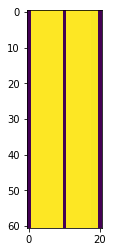

In [611]:
import numpy as np
from types import SimpleNamespace

sim = SimpleNamespace()
sim.res = 0.05
sim.L, sim.W = 3, 1
sim.L_in, sim.W_in = int(sim.L/sim.res), int(sim.W/sim.res)  
sim.L_n,  sim.W_n  = sim.L_in + 1, sim.W_in + 1

sim.w = np.array([4, 1/4, 1, 1/4, 1, 1/4, 1, 1/4, 1])/9
sim.e = np.array([[0,0], [1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])

sim.dt = 0.01
sim.c = sim.res/sim.dt
sim.nu = 10
sim.tau = 3*(sim.nu*(sim.dt/sim.res**2) + 1)
sim.m = 1
sim.P = 1

par = boltzmann_sim(sim)

In [ ]:
# replaced by tensor dot in code 
np.shape(np.mean(np.reshape(par.n, (21, 6, 9, 1)) * sim.e, axis = 2))